In [1]:
%matplotlib inline

import os
while 'source' not in os.listdir():
    os.chdir('..')
os.chdir('source')

FORCE = False

import gpu

In [2]:
from util import getHashId


props={
    'path'          : 'data',
    'seed'          : 42,
    'split'         : 0.8,
    'test_split'    : 0.5,
    'control'       : True,
    'huntington'    : False,
    'left'          : True,
    'right'         : True,
    'threshold'     : None,
    'binarize'      : False,
    'not_connected' : False,
    'single'        : None,
    'features'      : [],
    'features_vox'  : [],
    'radiomics'     : [
        #{'sp':'native','im':'t1','fe':['b25'],'fi':['roi','t1_mask']},
    ],
    'space'         : 'native',
    'radiomics_vox' : [
        {'im':'t1','fe':['k5_b25','k7_b25','k9_b25','k11_b25','k13_b25','k15_b25','k17_b25','k19_b25','k21_b25']},
    ],
    'rad_vox_norm'  : 'norm',
    'inps'          : ['coords'],
    'features_clin' : None,
    'outp'          : 'diffusion_md',
    'balance_data'  : False,
    'exclude'       : ['t1t2','normalized'],
    'include_warp'  : True,
    'collapse_max'  : False,
    'collapse_bin'  : False,
}

architecture={
    'activation'    : 'relu',
    'layers'        : [1024,512,256,128],
    'loss'          : 'MSE',
    'learning_rate' : 0.001,
    'batch_size'    : 10000,
    'patience'      : 7,
}

HASHID, HASH = getHashId(architecture,props)
print(HASH)

relu_10000_1024_512_256_128_0001_MSE_7_0_0_0_0_1_t1t2_normalized_e_n_e_0_1_e_1_0_diffusion_fa_data_norm_e_k5_b25_k7_b25_k9_b25_k11_b25_k13_b25_k15_b25_k17_b25_k19_b25_k21_b25_t1_1_42_n_native_08_05_n


In [3]:
from DataGenerator import DataGenerator

gen = DataGenerator(**props)
train, val, test = gen.getData()

print('train')
print(train[0].shape)
print(train[1].shape)
print('validation')
print(val[0].shape)
print(val[1].shape)
print('test')
print(test[0].shape)
print(test[1].shape)

train
(631390, 828)
(631390, 1)
validation
(74368, 828)
(74368, 1)
test
(85358, 828)
(85358, 1)


In [4]:
from Model import *
from tensorflow.keras.optimizers import Adam

path = props['path']+'/models'

stop = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=architecture['patience'],
)
save = tf.keras.callbacks.ModelCheckpoint(
    filepath=path+'/{}.weights.h5'.format(HASHID),
    monitor='val_loss',
    mode='min',
    save_best_only=True,
    save_weights_only=True,
)

model = buildModel(train[0].shape[1], train[1].shape[1], activation=architecture['activation'], layers=architecture['layers'])

model.compile(loss=locals()[architecture['loss']], optimizer=Adam(learning_rate=architecture['learning_rate']), jit_compile=True, metrics=[STD,MAE])

model.summary()

Model: "FFN"


_________________________________________________________________


 Layer (type)                Output Shape              Param #   


 input_1 (InputLayer)        [(None, 828)]             0         


 dense (Dense)               (None, 1024)              848896    


 dense_1 (Dense)             (None, 512)               524800    


 dense_2 (Dense)             (None, 256)               131328    


 dense_3 (Dense)             (None, 128)               32896     


 dense_4 (Dense)             (None, 1)                 129       


Total params: 1538049 (5.87 MB)


Trainable params: 1538049 (5.87 MB)


Non-trainable params: 0 (0.00 Byte)


_________________________________________________________________


In [5]:
import os
from util import pickleSave

if FORCE or not os.path.exists(path+'/{}.pkl'.format(HASHID)):
    history = model.fit(DataWrapper(train,architecture['batch_size']),
        validation_data=DataWrapper(val,architecture['batch_size'],False),
        epochs=10000,
        verbose=1,
        callbacks = [save,stop],
    )
    pickleSave(path+'/{}.pkl'.format(HASHID), history.history)

model.load_weights(path+'/{}.weights.h5'.format(HASHID))

Epoch 1/10000


 1/64 [..............................] - ETA: 1:39 - loss: 0.0386 - STD: 0.0191 - MAE: 0.1778

 4/64 [>.............................] - ETA: 1s - loss: 0.0451 - STD: 0.0052 - MAE: 0.1892  

 5/64 [=>............................] - ETA: 2s - loss: 0.0455 - STD: 0.0042 - MAE: 0.1900

 6/64 [=>............................] - ETA: 2s - loss: 0.0458 - STD: 0.0035 - MAE: 0.1906

 7/64 [==>...........................] - ETA: 2s - loss: 0.0461 - STD: 0.0030 - MAE: 0.1911

 8/64 [==>...........................] - ETA: 2s - loss: 0.0463 - STD: 0.0026 - MAE: 0.1915

 9/64 [===>..........................] - ETA: 2s - loss: 0.0464 - STD: 0.0023 - MAE: 0.1917

10/64 [===>..........................] - ETA: 2s - loss: 0.0465 - STD: 0.0021 - MAE: 0.1918

11/64 [====>.........................] - ETA: 2s - loss: 0.0465 - STD: 0.0019 - MAE: 0.1920

12/64 [====>.........................] - ETA: 2s - loss: 0.0465 - STD: 0.0017 - MAE: 0.1920

13/64 [=====>........................] - ETA: 2s - loss: 0.0466 - STD: 0.0016 - MAE: 0.1922

14/64 [=====>........................] - ETA: 2s - loss: 0.0467 - STD: 0.0015 - MAE: 0.1923

15/64 [======>.......................] - ETA: 2s - loss: 0.0467 - STD: 0.0014 - MAE: 0.1924

16/64 [======>.......................] - ETA: 2s - loss: 0.0468 - STD: 0.0013 - MAE: 0.1925

17/64 [======>.......................] - ETA: 2s - loss: 0.0468 - STD: 0.0012 - MAE: 0.1926

18/64 [=======>......................] - ETA: 2s - loss: 0.0468 - STD: 0.0012 - MAE: 0.1926

19/64 [=======>......................] - ETA: 2s - loss: 0.0469 - STD: 0.0011 - MAE: 0.1927

20/64 [========>.....................] - ETA: 2s - loss: 0.0469 - STD: 0.0010 - MAE: 0.1928

21/64 [========>.....................] - ETA: 2s - loss: 0.0469 - STD: 9.8835e-04 - MAE: 0.1928

22/64 [=========>....................] - ETA: 2s - loss: 0.0470 - STD: 9.4343e-04 - MAE: 0.1929

23/64 [=========>....................] - ETA: 2s - loss: 0.0470 - STD: 9.0241e-04 - MAE: 0.1929

24/64 [==========>...................] - ETA: 2s - loss: 0.0470 - STD: 8.6481e-04 - MAE: 0.1929

25/64 [==========>...................] - ETA: 2s - loss: 0.0470 - STD: 8.3022e-04 - MAE: 0.1929

26/64 [===========>..................] - ETA: 2s - loss: 0.0470 - STD: 7.9829e-04 - MAE: 0.1929

27/64 [===========>..................] - ETA: 2s - loss: 0.0470 - STD: 7.6872e-04 - MAE: 0.1930

28/64 [============>.................] - ETA: 2s - loss: 0.0471 - STD: 7.4127e-04 - MAE: 0.1931

29/64 [============>.................] - ETA: 1s - loss: 0.0471 - STD: 7.1570e-04 - MAE: 0.1932

30/64 [=============>................] - ETA: 1s - loss: 0.0471 - STD: 6.9185e-04 - MAE: 0.1932

31/64 [=============>................] - ETA: 1s - loss: 0.0472 - STD: 6.6953e-04 - MAE: 0.1933

32/64 [==============>...............] - ETA: 1s - loss: 0.0472 - STD: 6.4861e-04 - MAE: 0.1933

33/64 [==============>...............] - ETA: 1s - loss: 0.0472 - STD: 6.2895e-04 - MAE: 0.1932

34/64 [==============>...............] - ETA: 1s - loss: 0.0472 - STD: 6.1045e-04 - MAE: 0.1933

35/64 [===============>..............] - ETA: 1s - loss: 0.0472 - STD: 5.9301e-04 - MAE: 0.1933

36/64 [===============>..............] - ETA: 1s - loss: 0.0472 - STD: 5.7654e-04 - MAE: 0.1933

37/64 [================>.............] - ETA: 1s - loss: 0.0472 - STD: 5.6096e-04 - MAE: 0.1933

38/64 [================>.............] - ETA: 1s - loss: 0.0472 - STD: 5.4620e-04 - MAE: 0.1933

39/64 [=================>............] - ETA: 1s - loss: 0.0472 - STD: 5.3219e-04 - MAE: 0.1934

42/64 [==================>...........] - ETA: 1s - loss: 0.0473 - STD: 4.9418e-04 - MAE: 0.1935

44/64 [===================>..........] - ETA: 1s - loss: 0.0473 - STD: 4.7171e-04 - MAE: 0.1935

45/64 [====================>.........] - ETA: 1s - loss: 0.0473 - STD: 4.6123e-04 - MAE: 0.1935

46/64 [====================>.........] - ETA: 1s - loss: 0.0473 - STD: 4.5120e-04 - MAE: 0.1935

47/64 [=====================>........] - ETA: 1s - loss: 0.0473 - STD: 4.4160e-04 - MAE: 0.1935

48/64 [=====================>........] - ETA: 1s - loss: 0.0473 - STD: 4.3240e-04 - MAE: 0.1936

49/64 [=====================>........] - ETA: 1s - loss: 0.0473 - STD: 4.2358e-04 - MAE: 0.1936

50/64 [======================>.......] - ETA: 0s - loss: 0.0473 - STD: 4.1511e-04 - MAE: 0.1936

51/64 [======================>.......] - ETA: 0s - loss: 0.0474 - STD: 4.0697e-04 - MAE: 0.1936

52/64 [=======================>......] - ETA: 0s - loss: 0.0474 - STD: 3.9914e-04 - MAE: 0.1936

53/64 [=======================>......] - ETA: 0s - loss: 0.0474 - STD: 3.9161e-04 - MAE: 0.1937

54/64 [========================>.....] - ETA: 0s - loss: 0.0474 - STD: 3.8436e-04 - MAE: 0.1937

55/64 [========================>.....] - ETA: 0s - loss: 0.0474 - STD: 3.7737e-04 - MAE: 0.1937

56/64 [=========================>....] - ETA: 0s - loss: 0.0474 - STD: 3.7063e-04 - MAE: 0.1937

57/64 [=========================>....] - ETA: 0s - loss: 0.0474 - STD: 3.6413e-04 - MAE: 0.1936

58/64 [==========================>...] - ETA: 0s - loss: 0.0474 - STD: 3.5785e-04 - MAE: 0.1936

59/64 [==========================>...] - ETA: 0s - loss: 0.0474 - STD: 3.5179e-04 - MAE: 0.1937

60/64 [===========================>..] - ETA: 0s - loss: 0.0474 - STD: 3.4592e-04 - MAE: 0.1936

61/64 [===========================>..] - ETA: 0s - loss: 0.0474 - STD: 3.4025e-04 - MAE: 0.1936

62/64 [============================>.] - ETA: 0s - loss: 0.0474 - STD: 3.3476e-04 - MAE: 0.1937

63/64 [============================>.] - ETA: 0s - loss: 0.0474 - STD: 3.2945e-04 - MAE: 0.1936

64/64 [==============================] - ETA: 0s - loss: 0.0474 - STD: 3.2430e-04 - MAE: 0.1936

64/64 [==============================] - 6s 77ms/step - loss: 0.0474 - STD: 3.2430e-04 - MAE: 0.1936 - val_loss: 0.0460 - val_STD: 9.3585e-24 - val_MAE: 0.1938


Epoch 2/10000


 1/64 [..............................] - ETA: 6s - loss: 0.0472 - STD: 0.0000e+00 - MAE: 0.1933

 2/64 [..............................] - ETA: 4s - loss: 0.0476 - STD: 0.0000e+00 - MAE: 0.1941

 3/64 [>.............................] - ETA: 4s - loss: 0.0475 - STD: 0.0000e+00 - MAE: 0.1939

 4/64 [>.............................] - ETA: 4s - loss: 0.0475 - STD: 0.0000e+00 - MAE: 0.1939

 5/64 [=>............................] - ETA: 4s - loss: 0.0475 - STD: 0.0000e+00 - MAE: 0.1939

 6/64 [=>............................] - ETA: 4s - loss: 0.0475 - STD: 0.0000e+00 - MAE: 0.1939

 7/64 [==>...........................] - ETA: 4s - loss: 0.0476 - STD: 0.0000e+00 - MAE: 0.1940

 8/64 [==>...........................] - ETA: 4s - loss: 0.0477 - STD: 0.0000e+00 - MAE: 0.1942

 9/64 [===>..........................] - ETA: 4s - loss: 0.0477 - STD: 0.0000e+00 - MAE: 0.1942

10/64 [===>..........................] - ETA: 3s - loss: 0.0477 - STD: 0.0000e+00 - MAE: 0.1943

11/64 [====>.........................] - ETA: 3s - loss: 0.0477 - STD: 0.0000e+00 - MAE: 0.1944

12/64 [====>.........................] - ETA: 3s - loss: 0.0477 - STD: 0.0000e+00 - MAE: 0.1944

13/64 [=====>........................] - ETA: 3s - loss: 0.0477 - STD: 0.0000e+00 - MAE: 0.1943

14/64 [=====>........................] - ETA: 3s - loss: 0.0477 - STD: 0.0000e+00 - MAE: 0.1943

15/64 [======>.......................] - ETA: 3s - loss: 0.0477 - STD: 0.0000e+00 - MAE: 0.1943

16/64 [======>.......................] - ETA: 3s - loss: 0.0477 - STD: 0.0000e+00 - MAE: 0.1943

17/64 [======>.......................] - ETA: 3s - loss: 0.0477 - STD: 0.0000e+00 - MAE: 0.1943

18/64 [=======>......................] - ETA: 3s - loss: 0.0477 - STD: 0.0000e+00 - MAE: 0.1942

19/64 [=======>......................] - ETA: 3s - loss: 0.0477 - STD: 0.0000e+00 - MAE: 0.1943

20/64 [========>.....................] - ETA: 3s - loss: 0.0477 - STD: 0.0000e+00 - MAE: 0.1943

21/64 [========>.....................] - ETA: 2s - loss: 0.0477 - STD: 0.0000e+00 - MAE: 0.1942

22/64 [=========>....................] - ETA: 2s - loss: 0.0477 - STD: 0.0000e+00 - MAE: 0.1942

23/64 [=========>....................] - ETA: 2s - loss: 0.0476 - STD: 0.0000e+00 - MAE: 0.1941

24/64 [==========>...................] - ETA: 2s - loss: 0.0476 - STD: 0.0000e+00 - MAE: 0.1942

25/64 [==========>...................] - ETA: 2s - loss: 0.0477 - STD: 0.0000e+00 - MAE: 0.1943

26/64 [===========>..................] - ETA: 2s - loss: 0.0477 - STD: 0.0000e+00 - MAE: 0.1942

27/64 [===========>..................] - ETA: 2s - loss: 0.0477 - STD: 0.0000e+00 - MAE: 0.1942

28/64 [============>.................] - ETA: 2s - loss: 0.0477 - STD: 0.0000e+00 - MAE: 0.1942

29/64 [============>.................] - ETA: 2s - loss: 0.0476 - STD: 0.0000e+00 - MAE: 0.1941

30/64 [=============>................] - ETA: 2s - loss: 0.0476 - STD: 0.0000e+00 - MAE: 0.1941

31/64 [=============>................] - ETA: 2s - loss: 0.0476 - STD: 0.0000e+00 - MAE: 0.1941

32/64 [==============>...............] - ETA: 2s - loss: 0.0476 - STD: 0.0000e+00 - MAE: 0.1942

33/64 [==============>...............] - ETA: 2s - loss: 0.0476 - STD: 0.0000e+00 - MAE: 0.1942

34/64 [==============>...............] - ETA: 1s - loss: 0.0476 - STD: 0.0000e+00 - MAE: 0.1942

35/64 [===============>..............] - ETA: 1s - loss: 0.0476 - STD: 0.0000e+00 - MAE: 0.1942

36/64 [===============>..............] - ETA: 1s - loss: 0.0476 - STD: 0.0000e+00 - MAE: 0.1942

37/64 [================>.............] - ETA: 1s - loss: 0.0476 - STD: 0.0000e+00 - MAE: 0.1942

38/64 [================>.............] - ETA: 1s - loss: 0.0476 - STD: 0.0000e+00 - MAE: 0.1942

39/64 [=================>............] - ETA: 1s - loss: 0.0476 - STD: 0.0000e+00 - MAE: 0.1942

40/64 [=================>............] - ETA: 1s - loss: 0.0476 - STD: 0.0000e+00 - MAE: 0.1942

41/64 [==================>...........] - ETA: 1s - loss: 0.0476 - STD: 0.0000e+00 - MAE: 0.1942

42/64 [==================>...........] - ETA: 1s - loss: 0.0476 - STD: 0.0000e+00 - MAE: 0.1941

43/64 [===================>..........] - ETA: 1s - loss: 0.0476 - STD: 0.0000e+00 - MAE: 0.1941

44/64 [===================>..........] - ETA: 1s - loss: 0.0476 - STD: 0.0000e+00 - MAE: 0.1941

45/64 [====================>.........] - ETA: 1s - loss: 0.0476 - STD: 0.0000e+00 - MAE: 0.1941

46/64 [====================>.........] - ETA: 1s - loss: 0.0476 - STD: 0.0000e+00 - MAE: 0.1941

47/64 [=====================>........] - ETA: 1s - loss: 0.0476 - STD: 0.0000e+00 - MAE: 0.1941

48/64 [=====================>........] - ETA: 1s - loss: 0.0476 - STD: 0.0000e+00 - MAE: 0.1940

50/64 [======================>.......] - ETA: 0s - loss: 0.0475 - STD: 0.0000e+00 - MAE: 0.1939

51/64 [======================>.......] - ETA: 0s - loss: 0.0476 - STD: 0.0000e+00 - MAE: 0.1939

52/64 [=======================>......] - ETA: 0s - loss: 0.0476 - STD: 0.0000e+00 - MAE: 0.1939

53/64 [=======================>......] - ETA: 0s - loss: 0.0476 - STD: 0.0000e+00 - MAE: 0.1939

54/64 [========================>.....] - ETA: 0s - loss: 0.0475 - STD: 0.0000e+00 - MAE: 0.1939

55/64 [========================>.....] - ETA: 0s - loss: 0.0475 - STD: 0.0000e+00 - MAE: 0.1939

56/64 [=========================>....] - ETA: 0s - loss: 0.0475 - STD: 0.0000e+00 - MAE: 0.1939

57/64 [=========================>....] - ETA: 0s - loss: 0.0475 - STD: 0.0000e+00 - MAE: 0.1939

58/64 [==========================>...] - ETA: 0s - loss: 0.0475 - STD: 0.0000e+00 - MAE: 0.1939

59/64 [==========================>...] - ETA: 0s - loss: 0.0475 - STD: 0.0000e+00 - MAE: 0.1939

60/64 [===========================>..] - ETA: 0s - loss: 0.0475 - STD: 0.0000e+00 - MAE: 0.1939

61/64 [===========================>..] - ETA: 0s - loss: 0.0475 - STD: 0.0000e+00 - MAE: 0.1939

62/64 [============================>.] - ETA: 0s - loss: 0.0475 - STD: 0.0000e+00 - MAE: 0.1939

63/64 [============================>.] - ETA: 0s - loss: 0.0475 - STD: 0.0000e+00 - MAE: 0.1939

64/64 [==============================] - ETA: 0s - loss: 0.0475 - STD: 0.0000e+00 - MAE: 0.1939

64/64 [==============================] - 4s 64ms/step - loss: 0.0475 - STD: 0.0000e+00 - MAE: 0.1939 - val_loss: 0.0460 - val_STD: 8.1047e-24 - val_MAE: 0.1938


Epoch 3/10000


 1/64 [..............................] - ETA: 6s - loss: 0.0474 - STD: 0.0000e+00 - MAE: 0.1933

 2/64 [..............................] - ETA: 3s - loss: 0.0478 - STD: 0.0000e+00 - MAE: 0.1942

 3/64 [>.............................] - ETA: 3s - loss: 0.0476 - STD: 0.0000e+00 - MAE: 0.1939

 4/64 [>.............................] - ETA: 3s - loss: 0.0474 - STD: 0.0000e+00 - MAE: 0.1937

 5/64 [=>............................] - ETA: 3s - loss: 0.0475 - STD: 0.0000e+00 - MAE: 0.1938

 6/64 [=>............................] - ETA: 3s - loss: 0.0475 - STD: 0.0000e+00 - MAE: 0.1938

 7/64 [==>...........................] - ETA: 3s - loss: 0.0474 - STD: 0.0000e+00 - MAE: 0.1936

 8/64 [==>...........................] - ETA: 3s - loss: 0.0475 - STD: 0.0000e+00 - MAE: 0.1939

 9/64 [===>..........................] - ETA: 3s - loss: 0.0476 - STD: 0.0000e+00 - MAE: 0.1941

10/64 [===>..........................] - ETA: 3s - loss: 0.0476 - STD: 0.0000e+00 - MAE: 0.1940

11/64 [====>.........................] - ETA: 3s - loss: 0.0475 - STD: 0.0000e+00 - MAE: 0.1940

12/64 [====>.........................] - ETA: 3s - loss: 0.0475 - STD: 0.0000e+00 - MAE: 0.1940

13/64 [=====>........................] - ETA: 3s - loss: 0.0476 - STD: 0.0000e+00 - MAE: 0.1941

14/64 [=====>........................] - ETA: 2s - loss: 0.0476 - STD: 0.0000e+00 - MAE: 0.1940

15/64 [======>.......................] - ETA: 2s - loss: 0.0476 - STD: 0.0000e+00 - MAE: 0.1941

16/64 [======>.......................] - ETA: 2s - loss: 0.0476 - STD: 0.0000e+00 - MAE: 0.1941

17/64 [======>.......................] - ETA: 2s - loss: 0.0476 - STD: 0.0000e+00 - MAE: 0.1940

18/64 [=======>......................] - ETA: 2s - loss: 0.0475 - STD: 0.0000e+00 - MAE: 0.1939

19/64 [=======>......................] - ETA: 2s - loss: 0.0475 - STD: 0.0000e+00 - MAE: 0.1939

20/64 [========>.....................] - ETA: 2s - loss: 0.0475 - STD: 0.0000e+00 - MAE: 0.1939

21/64 [========>.....................] - ETA: 2s - loss: 0.0475 - STD: 0.0000e+00 - MAE: 0.1940

22/64 [=========>....................] - ETA: 2s - loss: 0.0475 - STD: 0.0000e+00 - MAE: 0.1938

23/64 [=========>....................] - ETA: 2s - loss: 0.0475 - STD: 0.0000e+00 - MAE: 0.1939

24/64 [==========>...................] - ETA: 2s - loss: 0.0475 - STD: 0.0000e+00 - MAE: 0.1939

25/64 [==========>...................] - ETA: 2s - loss: 0.0475 - STD: 0.0000e+00 - MAE: 0.1939

26/64 [===========>..................] - ETA: 2s - loss: 0.0475 - STD: 0.0000e+00 - MAE: 0.1939

27/64 [===========>..................] - ETA: 2s - loss: 0.0475 - STD: 0.0000e+00 - MAE: 0.1940

28/64 [============>.................] - ETA: 2s - loss: 0.0476 - STD: 0.0000e+00 - MAE: 0.1940

29/64 [============>.................] - ETA: 2s - loss: 0.0475 - STD: 0.0000e+00 - MAE: 0.1940

30/64 [=============>................] - ETA: 2s - loss: 0.0476 - STD: 0.0000e+00 - MAE: 0.1940

31/64 [=============>................] - ETA: 1s - loss: 0.0475 - STD: 0.0000e+00 - MAE: 0.1940

32/64 [==============>...............] - ETA: 1s - loss: 0.0475 - STD: 0.0000e+00 - MAE: 0.1940

33/64 [==============>...............] - ETA: 1s - loss: 0.0476 - STD: 0.0000e+00 - MAE: 0.1940

34/64 [==============>...............] - ETA: 1s - loss: 0.0476 - STD: 0.0000e+00 - MAE: 0.1940

35/64 [===============>..............] - ETA: 1s - loss: 0.0476 - STD: 0.0000e+00 - MAE: 0.1940

36/64 [===============>..............] - ETA: 1s - loss: 0.0475 - STD: 0.0000e+00 - MAE: 0.1940

37/64 [================>.............] - ETA: 1s - loss: 0.0476 - STD: 0.0000e+00 - MAE: 0.1940

38/64 [================>.............] - ETA: 1s - loss: 0.0476 - STD: 0.0000e+00 - MAE: 0.1941

39/64 [=================>............] - ETA: 1s - loss: 0.0476 - STD: 0.0000e+00 - MAE: 0.1941

40/64 [=================>............] - ETA: 1s - loss: 0.0476 - STD: 0.0000e+00 - MAE: 0.1940

41/64 [==================>...........] - ETA: 1s - loss: 0.0476 - STD: 0.0000e+00 - MAE: 0.1940

42/64 [==================>...........] - ETA: 1s - loss: 0.0476 - STD: 0.0000e+00 - MAE: 0.1940

43/64 [===================>..........] - ETA: 1s - loss: 0.0476 - STD: 0.0000e+00 - MAE: 0.1941

44/64 [===================>..........] - ETA: 1s - loss: 0.0476 - STD: 0.0000e+00 - MAE: 0.1941

45/64 [====================>.........] - ETA: 1s - loss: 0.0476 - STD: 0.0000e+00 - MAE: 0.1940

46/64 [====================>.........] - ETA: 1s - loss: 0.0475 - STD: 0.0000e+00 - MAE: 0.1940

47/64 [=====================>........] - ETA: 1s - loss: 0.0476 - STD: 0.0000e+00 - MAE: 0.1940

48/64 [=====================>........] - ETA: 0s - loss: 0.0476 - STD: 0.0000e+00 - MAE: 0.1940

49/64 [=====================>........] - ETA: 0s - loss: 0.0476 - STD: 0.0000e+00 - MAE: 0.1940

50/64 [======================>.......] - ETA: 0s - loss: 0.0476 - STD: 0.0000e+00 - MAE: 0.1940

51/64 [======================>.......] - ETA: 0s - loss: 0.0476 - STD: 0.0000e+00 - MAE: 0.1940

52/64 [=======================>......] - ETA: 0s - loss: 0.0476 - STD: 0.0000e+00 - MAE: 0.1940

53/64 [=======================>......] - ETA: 0s - loss: 0.0476 - STD: 0.0000e+00 - MAE: 0.1940

54/64 [========================>.....] - ETA: 0s - loss: 0.0476 - STD: 0.0000e+00 - MAE: 0.1940

55/64 [========================>.....] - ETA: 0s - loss: 0.0476 - STD: 0.0000e+00 - MAE: 0.1940

56/64 [=========================>....] - ETA: 0s - loss: 0.0475 - STD: 0.0000e+00 - MAE: 0.1940

57/64 [=========================>....] - ETA: 0s - loss: 0.0475 - STD: 0.0000e+00 - MAE: 0.1940

58/64 [==========================>...] - ETA: 0s - loss: 0.0475 - STD: 0.0000e+00 - MAE: 0.1940

59/64 [==========================>...] - ETA: 0s - loss: 0.0475 - STD: 0.0000e+00 - MAE: 0.1939

60/64 [===========================>..] - ETA: 0s - loss: 0.0475 - STD: 0.0000e+00 - MAE: 0.1939

62/64 [============================>.] - ETA: 0s - loss: 0.0475 - STD: 0.0000e+00 - MAE: 0.1940

63/64 [============================>.] - ETA: 0s - loss: 0.0475 - STD: 0.0000e+00 - MAE: 0.1940

64/64 [==============================] - ETA: 0s - loss: 0.0475 - STD: 0.0000e+00 - MAE: 0.1940

64/64 [==============================] - 4s 62ms/step - loss: 0.0475 - STD: 0.0000e+00 - MAE: 0.1940 - val_loss: 0.0460 - val_STD: 8.1047e-24 - val_MAE: 0.1938


Epoch 4/10000


 1/64 [..............................] - ETA: 6s - loss: 0.0473 - STD: 0.0000e+00 - MAE: 0.1933

 2/64 [..............................] - ETA: 3s - loss: 0.0479 - STD: 0.0000e+00 - MAE: 0.1945

 3/64 [>.............................] - ETA: 3s - loss: 0.0478 - STD: 0.0000e+00 - MAE: 0.1945

 4/64 [>.............................] - ETA: 3s - loss: 0.0477 - STD: 0.0000e+00 - MAE: 0.1944

 5/64 [=>............................] - ETA: 3s - loss: 0.0476 - STD: 0.0000e+00 - MAE: 0.1941

 7/64 [==>...........................] - ETA: 3s - loss: 0.0475 - STD: 0.0000e+00 - MAE: 0.1938

 8/64 [==>...........................] - ETA: 3s - loss: 0.0476 - STD: 0.0000e+00 - MAE: 0.1939

 9/64 [===>..........................] - ETA: 3s - loss: 0.0476 - STD: 0.0000e+00 - MAE: 0.1939

10/64 [===>..........................] - ETA: 2s - loss: 0.0475 - STD: 0.0000e+00 - MAE: 0.1939

11/64 [====>.........................] - ETA: 2s - loss: 0.0476 - STD: 0.0000e+00 - MAE: 0.1940

12/64 [====>.........................] - ETA: 2s - loss: 0.0475 - STD: 0.0000e+00 - MAE: 0.1940

13/64 [=====>........................] - ETA: 2s - loss: 0.0476 - STD: 0.0000e+00 - MAE: 0.1940

14/64 [=====>........................] - ETA: 2s - loss: 0.0476 - STD: 0.0000e+00 - MAE: 0.1939

15/64 [======>.......................] - ETA: 2s - loss: 0.0475 - STD: 0.0000e+00 - MAE: 0.1939

16/64 [======>.......................] - ETA: 2s - loss: 0.0475 - STD: 0.0000e+00 - MAE: 0.1939

17/64 [======>.......................] - ETA: 2s - loss: 0.0475 - STD: 0.0000e+00 - MAE: 0.1939

18/64 [=======>......................] - ETA: 2s - loss: 0.0476 - STD: 0.0000e+00 - MAE: 0.1940

19/64 [=======>......................] - ETA: 2s - loss: 0.0476 - STD: 0.0000e+00 - MAE: 0.1940

20/64 [========>.....................] - ETA: 2s - loss: 0.0476 - STD: 0.0000e+00 - MAE: 0.1940

21/64 [========>.....................] - ETA: 2s - loss: 0.0476 - STD: 0.0000e+00 - MAE: 0.1941

22/64 [=========>....................] - ETA: 2s - loss: 0.0476 - STD: 0.0000e+00 - MAE: 0.1940

23/64 [=========>....................] - ETA: 2s - loss: 0.0476 - STD: 0.0000e+00 - MAE: 0.1941

24/64 [==========>...................] - ETA: 2s - loss: 0.0476 - STD: 0.0000e+00 - MAE: 0.1941

25/64 [==========>...................] - ETA: 2s - loss: 0.0476 - STD: 0.0000e+00 - MAE: 0.1941

26/64 [===========>..................] - ETA: 2s - loss: 0.0476 - STD: 0.0000e+00 - MAE: 0.1942

27/64 [===========>..................] - ETA: 2s - loss: 0.0476 - STD: 0.0000e+00 - MAE: 0.1942

28/64 [============>.................] - ETA: 2s - loss: 0.0476 - STD: 0.0000e+00 - MAE: 0.1942

29/64 [============>.................] - ETA: 2s - loss: 0.0476 - STD: 0.0000e+00 - MAE: 0.1942

30/64 [=============>................] - ETA: 1s - loss: 0.0477 - STD: 0.0000e+00 - MAE: 0.1942

31/64 [=============>................] - ETA: 1s - loss: 0.0476 - STD: 0.0000e+00 - MAE: 0.1941

32/64 [==============>...............] - ETA: 1s - loss: 0.0476 - STD: 0.0000e+00 - MAE: 0.1941

33/64 [==============>...............] - ETA: 1s - loss: 0.0476 - STD: 0.0000e+00 - MAE: 0.1941

34/64 [==============>...............] - ETA: 1s - loss: 0.0476 - STD: 0.0000e+00 - MAE: 0.1941

35/64 [===============>..............] - ETA: 1s - loss: 0.0476 - STD: 0.0000e+00 - MAE: 0.1941

36/64 [===============>..............] - ETA: 1s - loss: 0.0476 - STD: 0.0000e+00 - MAE: 0.1941

37/64 [================>.............] - ETA: 1s - loss: 0.0476 - STD: 0.0000e+00 - MAE: 0.1941

38/64 [================>.............] - ETA: 1s - loss: 0.0476 - STD: 0.0000e+00 - MAE: 0.1941

39/64 [=================>............] - ETA: 1s - loss: 0.0476 - STD: 0.0000e+00 - MAE: 0.1941

40/64 [=================>............] - ETA: 1s - loss: 0.0476 - STD: 0.0000e+00 - MAE: 0.1940

41/64 [==================>...........] - ETA: 1s - loss: 0.0476 - STD: 0.0000e+00 - MAE: 0.1940

42/64 [==================>...........] - ETA: 1s - loss: 0.0476 - STD: 0.0000e+00 - MAE: 0.1940

43/64 [===================>..........] - ETA: 1s - loss: 0.0476 - STD: 0.0000e+00 - MAE: 0.1940

44/64 [===================>..........] - ETA: 1s - loss: 0.0476 - STD: 0.0000e+00 - MAE: 0.1940

45/64 [====================>.........] - ETA: 1s - loss: 0.0476 - STD: 0.0000e+00 - MAE: 0.1940

46/64 [====================>.........] - ETA: 1s - loss: 0.0476 - STD: 0.0000e+00 - MAE: 0.1941

47/64 [=====================>........] - ETA: 1s - loss: 0.0476 - STD: 0.0000e+00 - MAE: 0.1941

48/64 [=====================>........] - ETA: 0s - loss: 0.0476 - STD: 0.0000e+00 - MAE: 0.1940

49/64 [=====================>........] - ETA: 0s - loss: 0.0475 - STD: 0.0000e+00 - MAE: 0.1940

50/64 [======================>.......] - ETA: 0s - loss: 0.0476 - STD: 0.0000e+00 - MAE: 0.1940

51/64 [======================>.......] - ETA: 0s - loss: 0.0476 - STD: 0.0000e+00 - MAE: 0.1940

52/64 [=======================>......] - ETA: 0s - loss: 0.0476 - STD: 0.0000e+00 - MAE: 0.1940

53/64 [=======================>......] - ETA: 0s - loss: 0.0475 - STD: 0.0000e+00 - MAE: 0.1940

54/64 [========================>.....] - ETA: 0s - loss: 0.0475 - STD: 0.0000e+00 - MAE: 0.1940

55/64 [========================>.....] - ETA: 0s - loss: 0.0475 - STD: 0.0000e+00 - MAE: 0.1940

56/64 [=========================>....] - ETA: 0s - loss: 0.0475 - STD: 0.0000e+00 - MAE: 0.1940

57/64 [=========================>....] - ETA: 0s - loss: 0.0475 - STD: 0.0000e+00 - MAE: 0.1940

58/64 [==========================>...] - ETA: 0s - loss: 0.0475 - STD: 0.0000e+00 - MAE: 0.1940

59/64 [==========================>...] - ETA: 0s - loss: 0.0475 - STD: 0.0000e+00 - MAE: 0.1939

60/64 [===========================>..] - ETA: 0s - loss: 0.0475 - STD: 0.0000e+00 - MAE: 0.1940

61/64 [===========================>..] - ETA: 0s - loss: 0.0475 - STD: 0.0000e+00 - MAE: 0.1939

62/64 [============================>.] - ETA: 0s - loss: 0.0475 - STD: 0.0000e+00 - MAE: 0.1939

63/64 [============================>.] - ETA: 0s - loss: 0.0475 - STD: 0.0000e+00 - MAE: 0.1939

64/64 [==============================] - ETA: 0s - loss: 0.0475 - STD: 0.0000e+00 - MAE: 0.1939

64/64 [==============================] - 4s 62ms/step - loss: 0.0475 - STD: 0.0000e+00 - MAE: 0.1939 - val_loss: 0.0460 - val_STD: 8.1047e-24 - val_MAE: 0.1938


Epoch 5/10000


 1/64 [..............................] - ETA: 5s - loss: 0.0469 - STD: 0.0000e+00 - MAE: 0.1929

 2/64 [..............................] - ETA: 4s - loss: 0.0470 - STD: 0.0000e+00 - MAE: 0.1932

 3/64 [>.............................] - ETA: 3s - loss: 0.0470 - STD: 0.0000e+00 - MAE: 0.1933

 4/64 [>.............................] - ETA: 3s - loss: 0.0471 - STD: 0.0000e+00 - MAE: 0.1932

 5/64 [=>............................] - ETA: 3s - loss: 0.0472 - STD: 0.0000e+00 - MAE: 0.1935

 6/64 [=>............................] - ETA: 3s - loss: 0.0472 - STD: 0.0000e+00 - MAE: 0.1934

 7/64 [==>...........................] - ETA: 3s - loss: 0.0471 - STD: 0.0000e+00 - MAE: 0.1932

 8/64 [==>...........................] - ETA: 3s - loss: 0.0471 - STD: 0.0000e+00 - MAE: 0.1931

 9/64 [===>..........................] - ETA: 3s - loss: 0.0472 - STD: 0.0000e+00 - MAE: 0.1933

10/64 [===>..........................] - ETA: 3s - loss: 0.0472 - STD: 0.0000e+00 - MAE: 0.1934

11/64 [====>.........................] - ETA: 3s - loss: 0.0472 - STD: 0.0000e+00 - MAE: 0.1934

12/64 [====>.........................] - ETA: 3s - loss: 0.0472 - STD: 0.0000e+00 - MAE: 0.1935

13/64 [=====>........................] - ETA: 3s - loss: 0.0473 - STD: 0.0000e+00 - MAE: 0.1936

14/64 [=====>........................] - ETA: 3s - loss: 0.0473 - STD: 0.0000e+00 - MAE: 0.1936

15/64 [======>.......................] - ETA: 2s - loss: 0.0473 - STD: 0.0000e+00 - MAE: 0.1937

16/64 [======>.......................] - ETA: 2s - loss: 0.0473 - STD: 0.0000e+00 - MAE: 0.1937

17/64 [======>.......................] - ETA: 2s - loss: 0.0474 - STD: 0.0000e+00 - MAE: 0.1938

18/64 [=======>......................] - ETA: 2s - loss: 0.0474 - STD: 0.0000e+00 - MAE: 0.1938

19/64 [=======>......................] - ETA: 2s - loss: 0.0474 - STD: 0.0000e+00 - MAE: 0.1938

20/64 [========>.....................] - ETA: 2s - loss: 0.0475 - STD: 0.0000e+00 - MAE: 0.1939

21/64 [========>.....................] - ETA: 2s - loss: 0.0475 - STD: 0.0000e+00 - MAE: 0.1939

22/64 [=========>....................] - ETA: 2s - loss: 0.0475 - STD: 0.0000e+00 - MAE: 0.1939

23/64 [=========>....................] - ETA: 2s - loss: 0.0475 - STD: 0.0000e+00 - MAE: 0.1939

24/64 [==========>...................] - ETA: 2s - loss: 0.0475 - STD: 0.0000e+00 - MAE: 0.1940

25/64 [==========>...................] - ETA: 2s - loss: 0.0475 - STD: 0.0000e+00 - MAE: 0.1939

26/64 [===========>..................] - ETA: 2s - loss: 0.0475 - STD: 0.0000e+00 - MAE: 0.1939

27/64 [===========>..................] - ETA: 2s - loss: 0.0474 - STD: 0.0000e+00 - MAE: 0.1939

28/64 [============>.................] - ETA: 2s - loss: 0.0474 - STD: 0.0000e+00 - MAE: 0.1939

29/64 [============>.................] - ETA: 2s - loss: 0.0475 - STD: 0.0000e+00 - MAE: 0.1939

30/64 [=============>................] - ETA: 2s - loss: 0.0475 - STD: 0.0000e+00 - MAE: 0.1939

31/64 [=============>................] - ETA: 1s - loss: 0.0475 - STD: 0.0000e+00 - MAE: 0.1939

32/64 [==============>...............] - ETA: 1s - loss: 0.0475 - STD: 0.0000e+00 - MAE: 0.1939

33/64 [==============>...............] - ETA: 1s - loss: 0.0475 - STD: 0.0000e+00 - MAE: 0.1939

34/64 [==============>...............] - ETA: 1s - loss: 0.0474 - STD: 0.0000e+00 - MAE: 0.1939

35/64 [===============>..............] - ETA: 1s - loss: 0.0475 - STD: 0.0000e+00 - MAE: 0.1939

36/64 [===============>..............] - ETA: 1s - loss: 0.0475 - STD: 0.0000e+00 - MAE: 0.1939

37/64 [================>.............] - ETA: 1s - loss: 0.0475 - STD: 0.0000e+00 - MAE: 0.1939

38/64 [================>.............] - ETA: 1s - loss: 0.0475 - STD: 0.0000e+00 - MAE: 0.1939

39/64 [=================>............] - ETA: 1s - loss: 0.0475 - STD: 0.0000e+00 - MAE: 0.1939

40/64 [=================>............] - ETA: 1s - loss: 0.0475 - STD: 0.0000e+00 - MAE: 0.1939

41/64 [==================>...........] - ETA: 1s - loss: 0.0475 - STD: 0.0000e+00 - MAE: 0.1939

42/64 [==================>...........] - ETA: 1s - loss: 0.0475 - STD: 0.0000e+00 - MAE: 0.1939

43/64 [===================>..........] - ETA: 1s - loss: 0.0475 - STD: 0.0000e+00 - MAE: 0.1939

44/64 [===================>..........] - ETA: 1s - loss: 0.0475 - STD: 0.0000e+00 - MAE: 0.1940

45/64 [====================>.........] - ETA: 1s - loss: 0.0475 - STD: 0.0000e+00 - MAE: 0.1940

46/64 [====================>.........] - ETA: 1s - loss: 0.0475 - STD: 0.0000e+00 - MAE: 0.1940

48/64 [=====================>........] - ETA: 0s - loss: 0.0475 - STD: 0.0000e+00 - MAE: 0.1940

49/64 [=====================>........] - ETA: 0s - loss: 0.0475 - STD: 0.0000e+00 - MAE: 0.1940

50/64 [======================>.......] - ETA: 0s - loss: 0.0475 - STD: 0.0000e+00 - MAE: 0.1940

51/64 [======================>.......] - ETA: 0s - loss: 0.0475 - STD: 0.0000e+00 - MAE: 0.1939

52/64 [=======================>......] - ETA: 0s - loss: 0.0475 - STD: 0.0000e+00 - MAE: 0.1939

53/64 [=======================>......] - ETA: 0s - loss: 0.0475 - STD: 0.0000e+00 - MAE: 0.1940

54/64 [========================>.....] - ETA: 0s - loss: 0.0475 - STD: 0.0000e+00 - MAE: 0.1940

55/64 [========================>.....] - ETA: 0s - loss: 0.0475 - STD: 0.0000e+00 - MAE: 0.1939

56/64 [=========================>....] - ETA: 0s - loss: 0.0475 - STD: 0.0000e+00 - MAE: 0.1939

57/64 [=========================>....] - ETA: 0s - loss: 0.0475 - STD: 0.0000e+00 - MAE: 0.1939

58/64 [==========================>...] - ETA: 0s - loss: 0.0475 - STD: 0.0000e+00 - MAE: 0.1939

59/64 [==========================>...] - ETA: 0s - loss: 0.0475 - STD: 0.0000e+00 - MAE: 0.1940

60/64 [===========================>..] - ETA: 0s - loss: 0.0475 - STD: 0.0000e+00 - MAE: 0.1940

61/64 [===========================>..] - ETA: 0s - loss: 0.0475 - STD: 0.0000e+00 - MAE: 0.1940

62/64 [============================>.] - ETA: 0s - loss: 0.0475 - STD: 0.0000e+00 - MAE: 0.1940

63/64 [============================>.] - ETA: 0s - loss: 0.0475 - STD: 0.0000e+00 - MAE: 0.1940

64/64 [==============================] - ETA: 0s - loss: 0.0475 - STD: 0.0000e+00 - MAE: 0.1940

64/64 [==============================] - 4s 62ms/step - loss: 0.0475 - STD: 0.0000e+00 - MAE: 0.1940 - val_loss: 0.0460 - val_STD: 8.1047e-24 - val_MAE: 0.1938


Epoch 6/10000


 1/64 [..............................] - ETA: 5s - loss: 0.0472 - STD: 0.0000e+00 - MAE: 0.1934

 2/64 [..............................] - ETA: 3s - loss: 0.0474 - STD: 0.0000e+00 - MAE: 0.1938

 3/64 [>.............................] - ETA: 3s - loss: 0.0478 - STD: 0.0000e+00 - MAE: 0.1944

 4/64 [>.............................] - ETA: 3s - loss: 0.0478 - STD: 0.0000e+00 - MAE: 0.1944

 5/64 [=>............................] - ETA: 3s - loss: 0.0478 - STD: 0.0000e+00 - MAE: 0.1944

 6/64 [=>............................] - ETA: 3s - loss: 0.0478 - STD: 0.0000e+00 - MAE: 0.1945

 7/64 [==>...........................] - ETA: 3s - loss: 0.0478 - STD: 0.0000e+00 - MAE: 0.1945

 8/64 [==>...........................] - ETA: 3s - loss: 0.0477 - STD: 0.0000e+00 - MAE: 0.1942

 9/64 [===>..........................] - ETA: 3s - loss: 0.0477 - STD: 0.0000e+00 - MAE: 0.1941

10/64 [===>..........................] - ETA: 3s - loss: 0.0476 - STD: 0.0000e+00 - MAE: 0.1940

11/64 [====>.........................] - ETA: 3s - loss: 0.0476 - STD: 0.0000e+00 - MAE: 0.1940

12/64 [====>.........................] - ETA: 3s - loss: 0.0476 - STD: 0.0000e+00 - MAE: 0.1940

13/64 [=====>........................] - ETA: 3s - loss: 0.0476 - STD: 0.0000e+00 - MAE: 0.1940

14/64 [=====>........................] - ETA: 2s - loss: 0.0476 - STD: 0.0000e+00 - MAE: 0.1940

15/64 [======>.......................] - ETA: 2s - loss: 0.0476 - STD: 0.0000e+00 - MAE: 0.1941

16/64 [======>.......................] - ETA: 2s - loss: 0.0476 - STD: 0.0000e+00 - MAE: 0.1940

17/64 [======>.......................] - ETA: 2s - loss: 0.0476 - STD: 0.0000e+00 - MAE: 0.1941

18/64 [=======>......................] - ETA: 2s - loss: 0.0476 - STD: 0.0000e+00 - MAE: 0.1940

19/64 [=======>......................] - ETA: 2s - loss: 0.0476 - STD: 0.0000e+00 - MAE: 0.1940

20/64 [========>.....................] - ETA: 2s - loss: 0.0476 - STD: 0.0000e+00 - MAE: 0.1940

21/64 [========>.....................] - ETA: 2s - loss: 0.0476 - STD: 0.0000e+00 - MAE: 0.1940

22/64 [=========>....................] - ETA: 2s - loss: 0.0476 - STD: 0.0000e+00 - MAE: 0.1940

23/64 [=========>....................] - ETA: 2s - loss: 0.0476 - STD: 0.0000e+00 - MAE: 0.1940

24/64 [==========>...................] - ETA: 2s - loss: 0.0476 - STD: 0.0000e+00 - MAE: 0.1941

25/64 [==========>...................] - ETA: 2s - loss: 0.0476 - STD: 0.0000e+00 - MAE: 0.1941

26/64 [===========>..................] - ETA: 2s - loss: 0.0476 - STD: 0.0000e+00 - MAE: 0.1940

27/64 [===========>..................] - ETA: 2s - loss: 0.0476 - STD: 0.0000e+00 - MAE: 0.1940

28/64 [============>.................] - ETA: 2s - loss: 0.0476 - STD: 0.0000e+00 - MAE: 0.1940

29/64 [============>.................] - ETA: 2s - loss: 0.0476 - STD: 0.0000e+00 - MAE: 0.1940

30/64 [=============>................] - ETA: 2s - loss: 0.0476 - STD: 0.0000e+00 - MAE: 0.1940

31/64 [=============>................] - ETA: 1s - loss: 0.0476 - STD: 0.0000e+00 - MAE: 0.1940

33/64 [==============>...............] - ETA: 1s - loss: 0.0476 - STD: 0.0000e+00 - MAE: 0.1941

34/64 [==============>...............] - ETA: 1s - loss: 0.0476 - STD: 0.0000e+00 - MAE: 0.1941

35/64 [===============>..............] - ETA: 1s - loss: 0.0476 - STD: 0.0000e+00 - MAE: 0.1941

36/64 [===============>..............] - ETA: 1s - loss: 0.0476 - STD: 0.0000e+00 - MAE: 0.1941

37/64 [================>.............] - ETA: 1s - loss: 0.0476 - STD: 0.0000e+00 - MAE: 0.1941

38/64 [================>.............] - ETA: 1s - loss: 0.0476 - STD: 0.0000e+00 - MAE: 0.1941

39/64 [=================>............] - ETA: 1s - loss: 0.0476 - STD: 0.0000e+00 - MAE: 0.1941

40/64 [=================>............] - ETA: 1s - loss: 0.0475 - STD: 0.0000e+00 - MAE: 0.1940

41/64 [==================>...........] - ETA: 1s - loss: 0.0475 - STD: 0.0000e+00 - MAE: 0.1940

42/64 [==================>...........] - ETA: 1s - loss: 0.0476 - STD: 0.0000e+00 - MAE: 0.1940

43/64 [===================>..........] - ETA: 1s - loss: 0.0475 - STD: 0.0000e+00 - MAE: 0.1940

44/64 [===================>..........] - ETA: 1s - loss: 0.0476 - STD: 0.0000e+00 - MAE: 0.1941

45/64 [====================>.........] - ETA: 1s - loss: 0.0476 - STD: 0.0000e+00 - MAE: 0.1941

46/64 [====================>.........] - ETA: 1s - loss: 0.0476 - STD: 0.0000e+00 - MAE: 0.1941

47/64 [=====================>........] - ETA: 0s - loss: 0.0476 - STD: 0.0000e+00 - MAE: 0.1941

48/64 [=====================>........] - ETA: 0s - loss: 0.0476 - STD: 0.0000e+00 - MAE: 0.1941

49/64 [=====================>........] - ETA: 0s - loss: 0.0476 - STD: 0.0000e+00 - MAE: 0.1941

50/64 [======================>.......] - ETA: 0s - loss: 0.0476 - STD: 0.0000e+00 - MAE: 0.1941

51/64 [======================>.......] - ETA: 0s - loss: 0.0476 - STD: 0.0000e+00 - MAE: 0.1941

52/64 [=======================>......] - ETA: 0s - loss: 0.0476 - STD: 0.0000e+00 - MAE: 0.1941

53/64 [=======================>......] - ETA: 0s - loss: 0.0476 - STD: 0.0000e+00 - MAE: 0.1941

54/64 [========================>.....] - ETA: 0s - loss: 0.0476 - STD: 0.0000e+00 - MAE: 0.1941

55/64 [========================>.....] - ETA: 0s - loss: 0.0476 - STD: 0.0000e+00 - MAE: 0.1940

56/64 [=========================>....] - ETA: 0s - loss: 0.0475 - STD: 0.0000e+00 - MAE: 0.1940

57/64 [=========================>....] - ETA: 0s - loss: 0.0475 - STD: 0.0000e+00 - MAE: 0.1940

58/64 [==========================>...] - ETA: 0s - loss: 0.0475 - STD: 0.0000e+00 - MAE: 0.1940

59/64 [==========================>...] - ETA: 0s - loss: 0.0475 - STD: 0.0000e+00 - MAE: 0.1940

60/64 [===========================>..] - ETA: 0s - loss: 0.0475 - STD: 0.0000e+00 - MAE: 0.1940

61/64 [===========================>..] - ETA: 0s - loss: 0.0475 - STD: 0.0000e+00 - MAE: 0.1940

62/64 [============================>.] - ETA: 0s - loss: 0.0475 - STD: 0.0000e+00 - MAE: 0.1940

63/64 [============================>.] - ETA: 0s - loss: 0.0475 - STD: 0.0000e+00 - MAE: 0.1940

64/64 [==============================] - ETA: 0s - loss: 0.0475 - STD: 0.0000e+00 - MAE: 0.1940

64/64 [==============================] - 4s 62ms/step - loss: 0.0475 - STD: 0.0000e+00 - MAE: 0.1940 - val_loss: 0.0460 - val_STD: 8.1047e-24 - val_MAE: 0.1938


Epoch 7/10000


 1/64 [..............................] - ETA: 6s - loss: 0.0475 - STD: 0.0000e+00 - MAE: 0.1937

 2/64 [..............................] - ETA: 4s - loss: 0.0477 - STD: 0.0000e+00 - MAE: 0.1943

 3/64 [>.............................] - ETA: 3s - loss: 0.0474 - STD: 0.0000e+00 - MAE: 0.1938

 4/64 [>.............................] - ETA: 3s - loss: 0.0474 - STD: 0.0000e+00 - MAE: 0.1937

 5/64 [=>............................] - ETA: 3s - loss: 0.0476 - STD: 0.0000e+00 - MAE: 0.1940

 6/64 [=>............................] - ETA: 3s - loss: 0.0475 - STD: 0.0000e+00 - MAE: 0.1939

 7/64 [==>...........................] - ETA: 3s - loss: 0.0475 - STD: 0.0000e+00 - MAE: 0.1938

 8/64 [==>...........................] - ETA: 3s - loss: 0.0476 - STD: 0.0000e+00 - MAE: 0.1940

 9/64 [===>..........................] - ETA: 3s - loss: 0.0476 - STD: 0.0000e+00 - MAE: 0.1941

10/64 [===>..........................] - ETA: 3s - loss: 0.0477 - STD: 0.0000e+00 - MAE: 0.1941

11/64 [====>.........................] - ETA: 3s - loss: 0.0477 - STD: 0.0000e+00 - MAE: 0.1942

12/64 [====>.........................] - ETA: 3s - loss: 0.0477 - STD: 0.0000e+00 - MAE: 0.1941

13/64 [=====>........................] - ETA: 3s - loss: 0.0476 - STD: 0.0000e+00 - MAE: 0.1941

14/64 [=====>........................] - ETA: 3s - loss: 0.0476 - STD: 0.0000e+00 - MAE: 0.1941

15/64 [======>.......................] - ETA: 2s - loss: 0.0475 - STD: 0.0000e+00 - MAE: 0.1940

16/64 [======>.......................] - ETA: 2s - loss: 0.0476 - STD: 0.0000e+00 - MAE: 0.1940

17/64 [======>.......................] - ETA: 2s - loss: 0.0476 - STD: 0.0000e+00 - MAE: 0.1940

18/64 [=======>......................] - ETA: 2s - loss: 0.0475 - STD: 0.0000e+00 - MAE: 0.1940

19/64 [=======>......................] - ETA: 2s - loss: 0.0475 - STD: 0.0000e+00 - MAE: 0.1939

20/64 [========>.....................] - ETA: 2s - loss: 0.0475 - STD: 0.0000e+00 - MAE: 0.1939

21/64 [========>.....................] - ETA: 2s - loss: 0.0475 - STD: 0.0000e+00 - MAE: 0.1939

22/64 [=========>....................] - ETA: 2s - loss: 0.0475 - STD: 0.0000e+00 - MAE: 0.1939

23/64 [=========>....................] - ETA: 2s - loss: 0.0475 - STD: 0.0000e+00 - MAE: 0.1940

24/64 [==========>...................] - ETA: 2s - loss: 0.0476 - STD: 0.0000e+00 - MAE: 0.1940

25/64 [==========>...................] - ETA: 2s - loss: 0.0476 - STD: 0.0000e+00 - MAE: 0.1941

26/64 [===========>..................] - ETA: 2s - loss: 0.0476 - STD: 0.0000e+00 - MAE: 0.1940

27/64 [===========>..................] - ETA: 2s - loss: 0.0476 - STD: 0.0000e+00 - MAE: 0.1941

28/64 [============>.................] - ETA: 2s - loss: 0.0476 - STD: 0.0000e+00 - MAE: 0.1941

29/64 [============>.................] - ETA: 2s - loss: 0.0476 - STD: 0.0000e+00 - MAE: 0.1940

30/64 [=============>................] - ETA: 2s - loss: 0.0476 - STD: 0.0000e+00 - MAE: 0.1941

31/64 [=============>................] - ETA: 1s - loss: 0.0476 - STD: 0.0000e+00 - MAE: 0.1941

32/64 [==============>...............] - ETA: 1s - loss: 0.0476 - STD: 0.0000e+00 - MAE: 0.1941

33/64 [==============>...............] - ETA: 1s - loss: 0.0476 - STD: 0.0000e+00 - MAE: 0.1941

34/64 [==============>...............] - ETA: 1s - loss: 0.0476 - STD: 0.0000e+00 - MAE: 0.1941

35/64 [===============>..............] - ETA: 1s - loss: 0.0476 - STD: 0.0000e+00 - MAE: 0.1941

36/64 [===============>..............] - ETA: 1s - loss: 0.0476 - STD: 0.0000e+00 - MAE: 0.1941

38/64 [================>.............] - ETA: 1s - loss: 0.0476 - STD: 0.0000e+00 - MAE: 0.1941

39/64 [=================>............] - ETA: 1s - loss: 0.0476 - STD: 0.0000e+00 - MAE: 0.1940

40/64 [=================>............] - ETA: 1s - loss: 0.0475 - STD: 0.0000e+00 - MAE: 0.1940

41/64 [==================>...........] - ETA: 1s - loss: 0.0475 - STD: 0.0000e+00 - MAE: 0.1940

42/64 [==================>...........] - ETA: 1s - loss: 0.0475 - STD: 0.0000e+00 - MAE: 0.1940

43/64 [===================>..........] - ETA: 1s - loss: 0.0476 - STD: 0.0000e+00 - MAE: 0.1941

44/64 [===================>..........] - ETA: 1s - loss: 0.0476 - STD: 0.0000e+00 - MAE: 0.1941

45/64 [====================>.........] - ETA: 1s - loss: 0.0476 - STD: 0.0000e+00 - MAE: 0.1941

46/64 [====================>.........] - ETA: 1s - loss: 0.0476 - STD: 0.0000e+00 - MAE: 0.1941

47/64 [=====================>........] - ETA: 1s - loss: 0.0476 - STD: 0.0000e+00 - MAE: 0.1941

48/64 [=====================>........] - ETA: 0s - loss: 0.0476 - STD: 0.0000e+00 - MAE: 0.1941

49/64 [=====================>........] - ETA: 0s - loss: 0.0476 - STD: 0.0000e+00 - MAE: 0.1941

50/64 [======================>.......] - ETA: 0s - loss: 0.0476 - STD: 0.0000e+00 - MAE: 0.1941

51/64 [======================>.......] - ETA: 0s - loss: 0.0476 - STD: 0.0000e+00 - MAE: 0.1941

52/64 [=======================>......] - ETA: 0s - loss: 0.0475 - STD: 0.0000e+00 - MAE: 0.1940

53/64 [=======================>......] - ETA: 0s - loss: 0.0475 - STD: 0.0000e+00 - MAE: 0.1940

54/64 [========================>.....] - ETA: 0s - loss: 0.0475 - STD: 0.0000e+00 - MAE: 0.1940

55/64 [========================>.....] - ETA: 0s - loss: 0.0475 - STD: 0.0000e+00 - MAE: 0.1940

56/64 [=========================>....] - ETA: 0s - loss: 0.0475 - STD: 0.0000e+00 - MAE: 0.1940

57/64 [=========================>....] - ETA: 0s - loss: 0.0475 - STD: 0.0000e+00 - MAE: 0.1940

58/64 [==========================>...] - ETA: 0s - loss: 0.0475 - STD: 0.0000e+00 - MAE: 0.1940

59/64 [==========================>...] - ETA: 0s - loss: 0.0475 - STD: 0.0000e+00 - MAE: 0.1940

60/64 [===========================>..] - ETA: 0s - loss: 0.0475 - STD: 0.0000e+00 - MAE: 0.1940

61/64 [===========================>..] - ETA: 0s - loss: 0.0475 - STD: 0.0000e+00 - MAE: 0.1940

62/64 [============================>.] - ETA: 0s - loss: 0.0475 - STD: 0.0000e+00 - MAE: 0.1939

63/64 [============================>.] - ETA: 0s - loss: 0.0475 - STD: 0.0000e+00 - MAE: 0.1940

64/64 [==============================] - ETA: 0s - loss: 0.0475 - STD: 0.0000e+00 - MAE: 0.1940

64/64 [==============================] - 4s 62ms/step - loss: 0.0475 - STD: 0.0000e+00 - MAE: 0.1940 - val_loss: 0.0460 - val_STD: 8.1047e-24 - val_MAE: 0.1938


Epoch 8/10000


 1/64 [..............................] - ETA: 5s - loss: 0.0477 - STD: 0.0000e+00 - MAE: 0.1944

 2/64 [..............................] - ETA: 3s - loss: 0.0478 - STD: 0.0000e+00 - MAE: 0.1948

 3/64 [>.............................] - ETA: 3s - loss: 0.0476 - STD: 0.0000e+00 - MAE: 0.1942

 4/64 [>.............................] - ETA: 3s - loss: 0.0478 - STD: 0.0000e+00 - MAE: 0.1945

 5/64 [=>............................] - ETA: 3s - loss: 0.0478 - STD: 0.0000e+00 - MAE: 0.1945

 6/64 [=>............................] - ETA: 3s - loss: 0.0478 - STD: 0.0000e+00 - MAE: 0.1945

 7/64 [==>...........................] - ETA: 3s - loss: 0.0478 - STD: 0.0000e+00 - MAE: 0.1945

 8/64 [==>...........................] - ETA: 3s - loss: 0.0478 - STD: 0.0000e+00 - MAE: 0.1946

 9/64 [===>..........................] - ETA: 3s - loss: 0.0477 - STD: 0.0000e+00 - MAE: 0.1943

10/64 [===>..........................] - ETA: 3s - loss: 0.0477 - STD: 0.0000e+00 - MAE: 0.1943

11/64 [====>.........................] - ETA: 3s - loss: 0.0477 - STD: 0.0000e+00 - MAE: 0.1942

12/64 [====>.........................] - ETA: 3s - loss: 0.0476 - STD: 0.0000e+00 - MAE: 0.1942

13/64 [=====>........................] - ETA: 2s - loss: 0.0476 - STD: 0.0000e+00 - MAE: 0.1942

14/64 [=====>........................] - ETA: 2s - loss: 0.0476 - STD: 0.0000e+00 - MAE: 0.1943

15/64 [======>.......................] - ETA: 2s - loss: 0.0476 - STD: 0.0000e+00 - MAE: 0.1942

16/64 [======>.......................] - ETA: 2s - loss: 0.0477 - STD: 0.0000e+00 - MAE: 0.1943

17/64 [======>.......................] - ETA: 2s - loss: 0.0477 - STD: 0.0000e+00 - MAE: 0.1944

18/64 [=======>......................] - ETA: 2s - loss: 0.0477 - STD: 0.0000e+00 - MAE: 0.1944

19/64 [=======>......................] - ETA: 2s - loss: 0.0477 - STD: 0.0000e+00 - MAE: 0.1944

20/64 [========>.....................] - ETA: 2s - loss: 0.0477 - STD: 0.0000e+00 - MAE: 0.1944

21/64 [========>.....................] - ETA: 2s - loss: 0.0478 - STD: 0.0000e+00 - MAE: 0.1944

22/64 [=========>....................] - ETA: 2s - loss: 0.0478 - STD: 0.0000e+00 - MAE: 0.1945

23/64 [=========>....................] - ETA: 2s - loss: 0.0478 - STD: 0.0000e+00 - MAE: 0.1945

24/64 [==========>...................] - ETA: 2s - loss: 0.0478 - STD: 0.0000e+00 - MAE: 0.1944

25/64 [==========>...................] - ETA: 2s - loss: 0.0477 - STD: 0.0000e+00 - MAE: 0.1943

26/64 [===========>..................] - ETA: 2s - loss: 0.0477 - STD: 0.0000e+00 - MAE: 0.1943

27/64 [===========>..................] - ETA: 2s - loss: 0.0477 - STD: 0.0000e+00 - MAE: 0.1943

28/64 [============>.................] - ETA: 2s - loss: 0.0477 - STD: 0.0000e+00 - MAE: 0.1943

29/64 [============>.................] - ETA: 2s - loss: 0.0476 - STD: 0.0000e+00 - MAE: 0.1942

30/64 [=============>................] - ETA: 2s - loss: 0.0476 - STD: 0.0000e+00 - MAE: 0.1942

31/64 [=============>................] - ETA: 1s - loss: 0.0476 - STD: 0.0000e+00 - MAE: 0.1942

32/64 [==============>...............] - ETA: 1s - loss: 0.0476 - STD: 0.0000e+00 - MAE: 0.1941

33/64 [==============>...............] - ETA: 1s - loss: 0.0476 - STD: 0.0000e+00 - MAE: 0.1941

34/64 [==============>...............] - ETA: 1s - loss: 0.0476 - STD: 0.0000e+00 - MAE: 0.1941

35/64 [===============>..............] - ETA: 1s - loss: 0.0476 - STD: 0.0000e+00 - MAE: 0.1941

37/64 [================>.............] - ETA: 1s - loss: 0.0476 - STD: 0.0000e+00 - MAE: 0.1941

38/64 [================>.............] - ETA: 1s - loss: 0.0476 - STD: 0.0000e+00 - MAE: 0.1941

39/64 [=================>............] - ETA: 1s - loss: 0.0476 - STD: 0.0000e+00 - MAE: 0.1941

40/64 [=================>............] - ETA: 1s - loss: 0.0475 - STD: 0.0000e+00 - MAE: 0.1940

41/64 [==================>...........] - ETA: 1s - loss: 0.0475 - STD: 0.0000e+00 - MAE: 0.1940

42/64 [==================>...........] - ETA: 1s - loss: 0.0476 - STD: 0.0000e+00 - MAE: 0.1941

43/64 [===================>..........] - ETA: 1s - loss: 0.0476 - STD: 0.0000e+00 - MAE: 0.1941

44/64 [===================>..........] - ETA: 1s - loss: 0.0475 - STD: 0.0000e+00 - MAE: 0.1940

45/64 [====================>.........] - ETA: 1s - loss: 0.0476 - STD: 0.0000e+00 - MAE: 0.1941

46/64 [====================>.........] - ETA: 1s - loss: 0.0476 - STD: 0.0000e+00 - MAE: 0.1941

47/64 [=====================>........] - ETA: 0s - loss: 0.0476 - STD: 0.0000e+00 - MAE: 0.1941

48/64 [=====================>........] - ETA: 0s - loss: 0.0476 - STD: 0.0000e+00 - MAE: 0.1940

49/64 [=====================>........] - ETA: 0s - loss: 0.0476 - STD: 0.0000e+00 - MAE: 0.1941

50/64 [======================>.......] - ETA: 0s - loss: 0.0476 - STD: 0.0000e+00 - MAE: 0.1941

51/64 [======================>.......] - ETA: 0s - loss: 0.0476 - STD: 0.0000e+00 - MAE: 0.1941

52/64 [=======================>......] - ETA: 0s - loss: 0.0475 - STD: 0.0000e+00 - MAE: 0.1940

53/64 [=======================>......] - ETA: 0s - loss: 0.0475 - STD: 0.0000e+00 - MAE: 0.1940

54/64 [========================>.....] - ETA: 0s - loss: 0.0475 - STD: 0.0000e+00 - MAE: 0.1940

55/64 [========================>.....] - ETA: 0s - loss: 0.0475 - STD: 0.0000e+00 - MAE: 0.1940

56/64 [=========================>....] - ETA: 0s - loss: 0.0475 - STD: 0.0000e+00 - MAE: 0.1940

57/64 [=========================>....] - ETA: 0s - loss: 0.0475 - STD: 0.0000e+00 - MAE: 0.1940

58/64 [==========================>...] - ETA: 0s - loss: 0.0475 - STD: 0.0000e+00 - MAE: 0.1940

59/64 [==========================>...] - ETA: 0s - loss: 0.0475 - STD: 0.0000e+00 - MAE: 0.1940

60/64 [===========================>..] - ETA: 0s - loss: 0.0475 - STD: 0.0000e+00 - MAE: 0.1940

61/64 [===========================>..] - ETA: 0s - loss: 0.0475 - STD: 0.0000e+00 - MAE: 0.1940

62/64 [============================>.] - ETA: 0s - loss: 0.0475 - STD: 0.0000e+00 - MAE: 0.1940

63/64 [============================>.] - ETA: 0s - loss: 0.0475 - STD: 0.0000e+00 - MAE: 0.1940

64/64 [==============================] - ETA: 0s - loss: 0.0475 - STD: 0.0000e+00 - MAE: 0.1940

64/64 [==============================] - 4s 62ms/step - loss: 0.0475 - STD: 0.0000e+00 - MAE: 0.1940 - val_loss: 0.0460 - val_STD: 8.1047e-24 - val_MAE: 0.1938


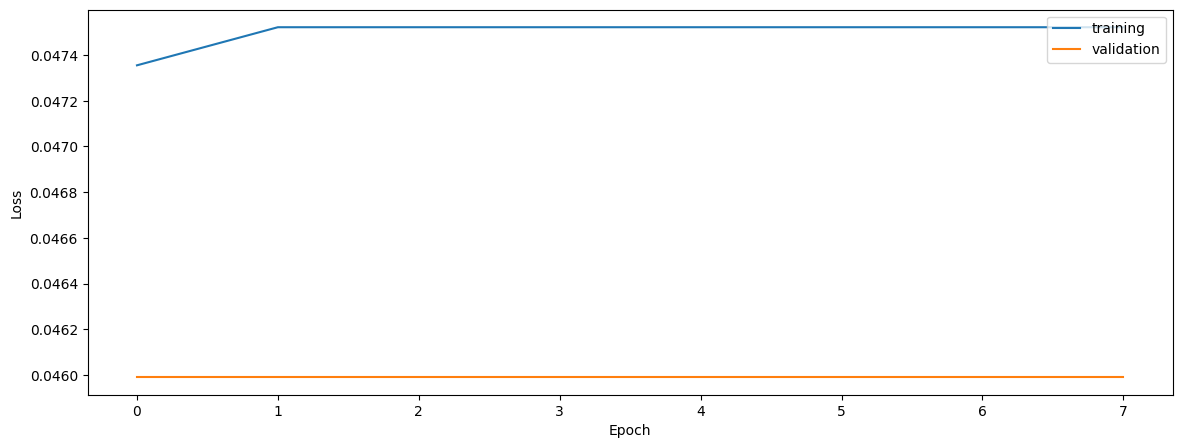

In [6]:
from util import pickleLoad
from visual import plotHistory

history = pickleLoad(path+'/{}.pkl'.format(HASHID))
plotHistory(history)

In [7]:
from util import getPearson, predictInBatches

train_pred = predictInBatches(model,train[0],architecture['batch_size'])
val_pred = predictInBatches(model,val[0],architecture['batch_size'])
test_pred = predictInBatches(model,test[0],architecture['batch_size'])

print('train')
print(getPearson(train[1],train_pred))
print(getPearson(val[1],val_pred))
print(getPearson(test[1],test_pred))

train
0.008644107351838565
0.02258232629412429
0.021048141109586523


In [8]:
print('native')
print(getPearson(train[1],train_pred))
print(getPearson(val[1],val_pred))
print(getPearson(test[1],test_pred))

native
0.008644107351838565
0.02258232629412429
0.021048141109586523


In [9]:
print('normalized')
print(getPearson(train[1][train[2]],train_pred[train[2]]))
print(getPearson(val[1][val[2]],val_pred[val[2]]))
print(getPearson(test[1][test[2]],test_pred[test[2]]))

normalized
0.0096074112340532
0.02168226782455104
0.02051423413785115


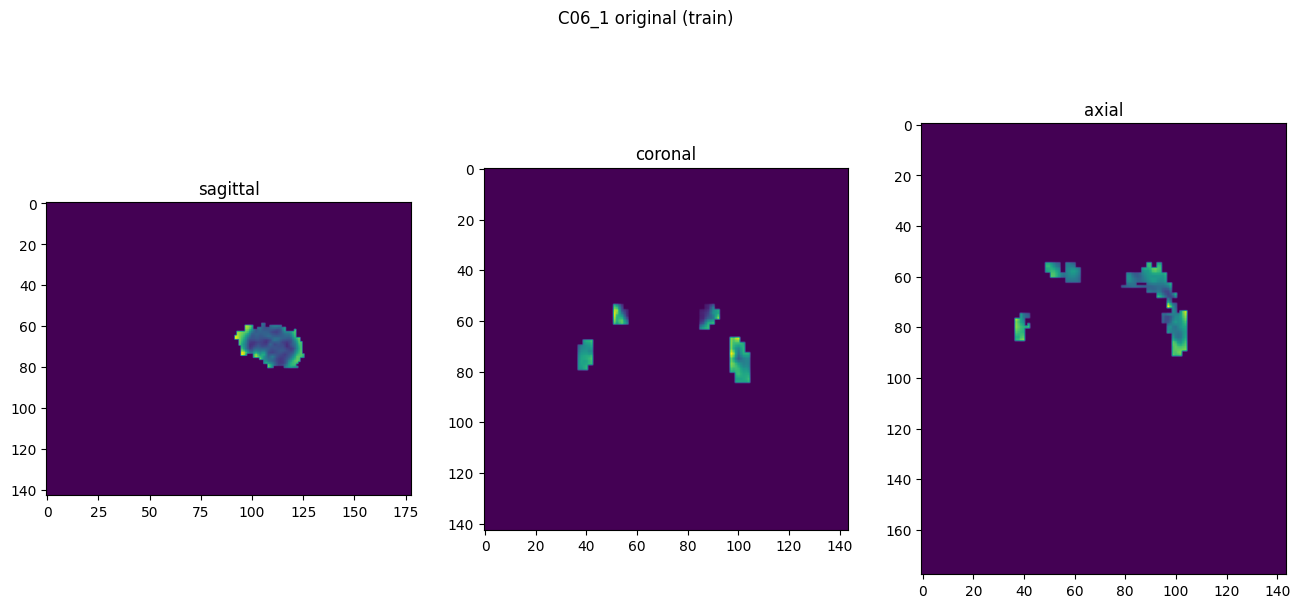

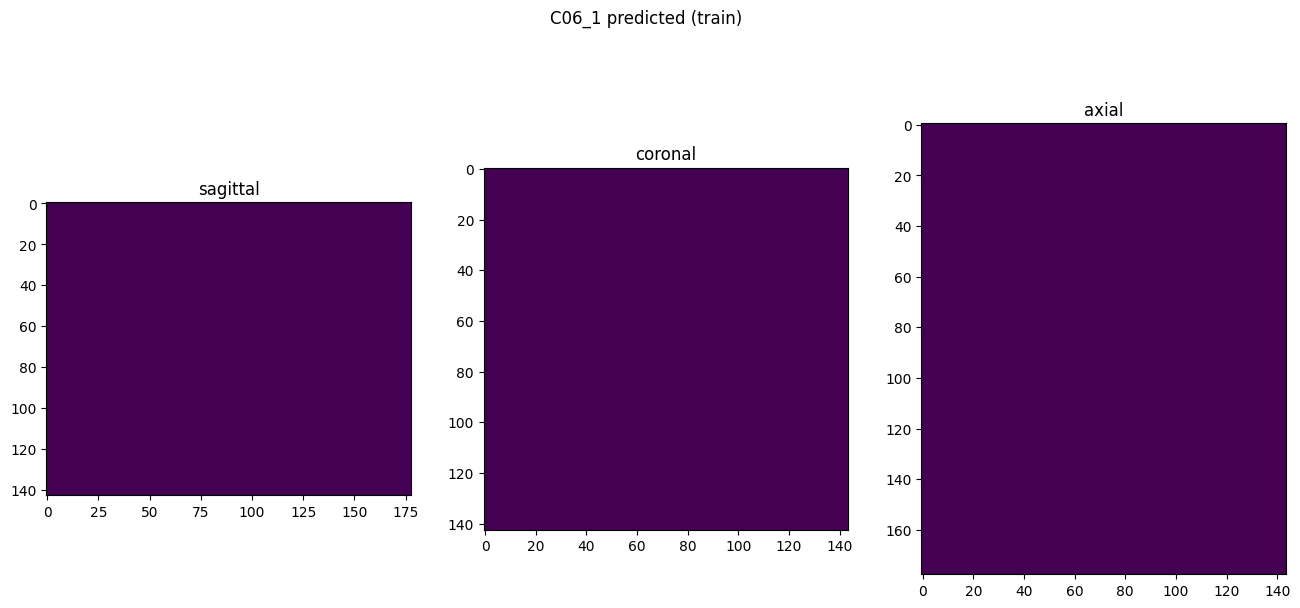

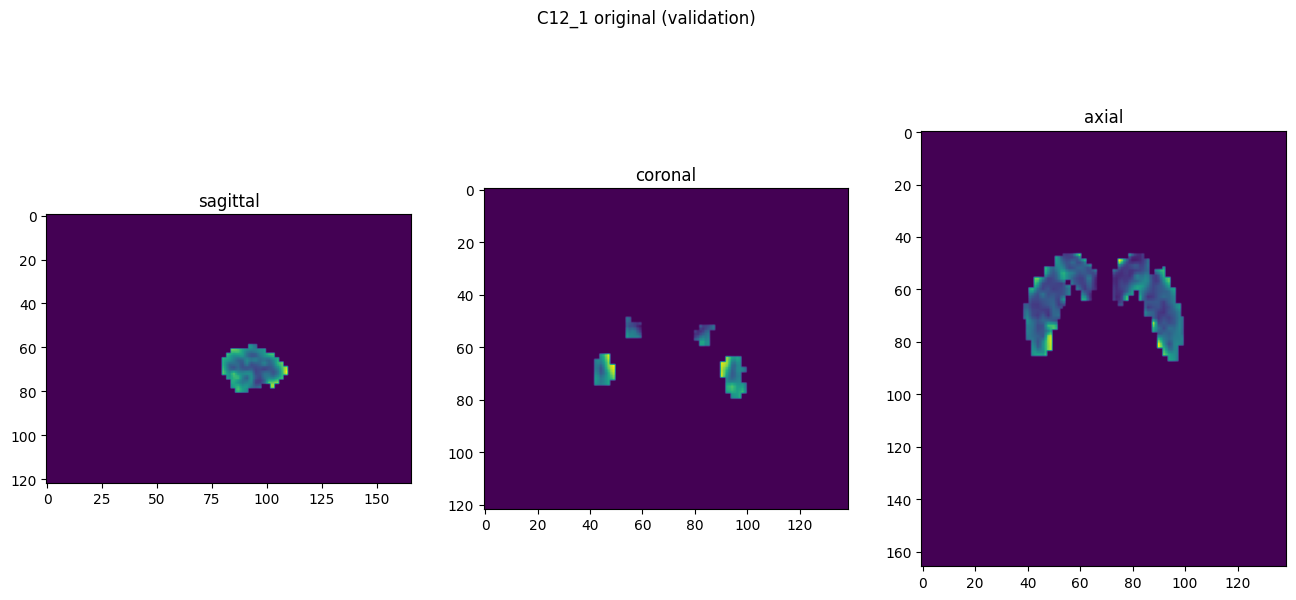

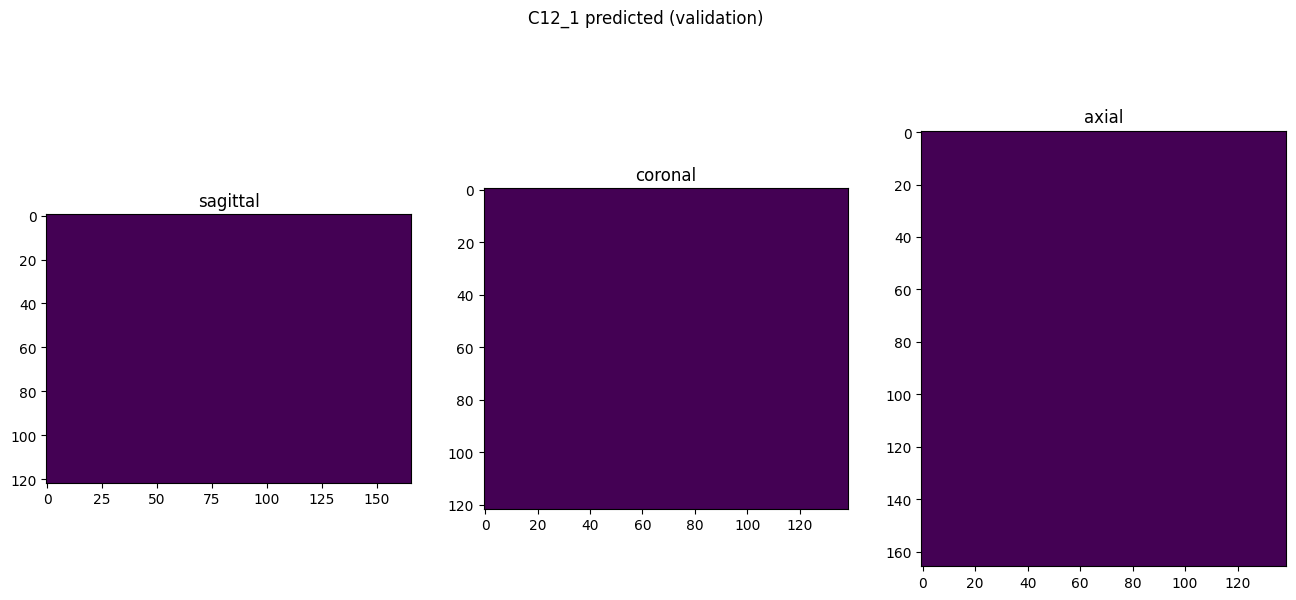

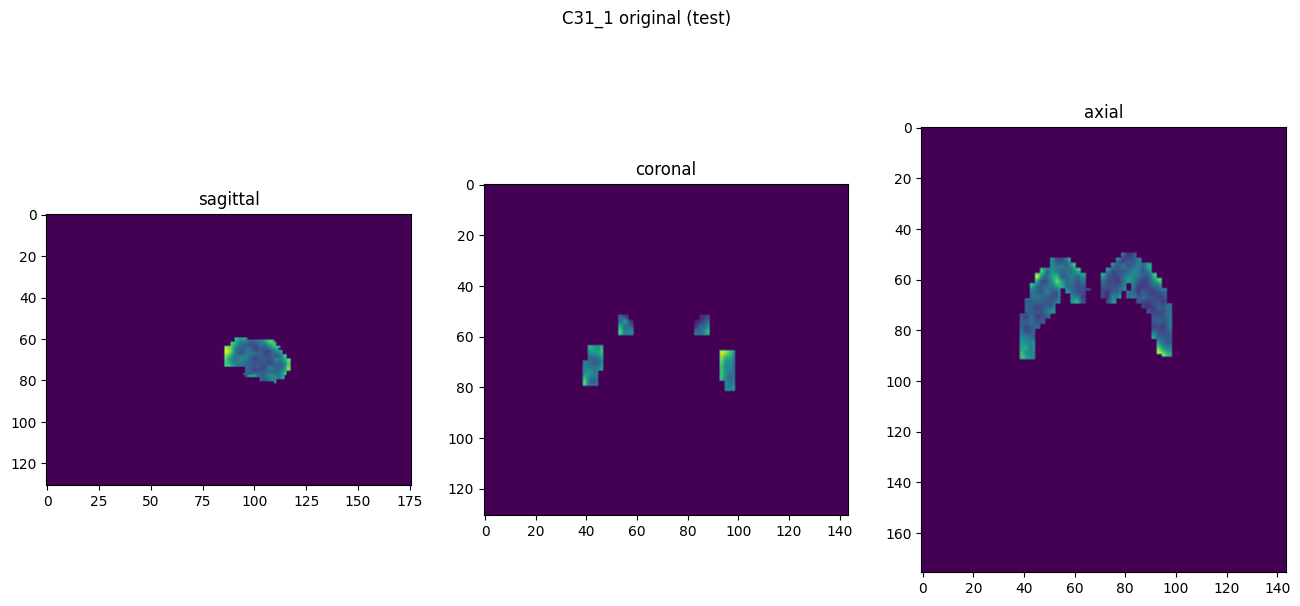

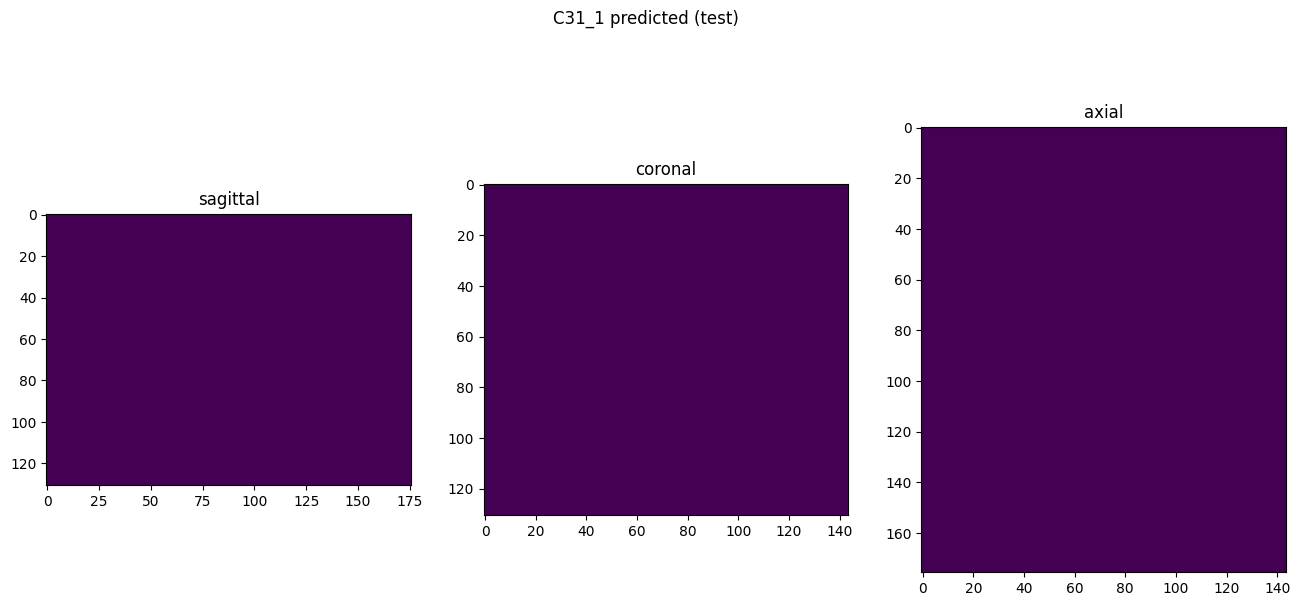

In [10]:
showResults(model, gen, threshold=None, background=False)